# Collisional Analysis - Differential Flow

[maruca2013]: https://doi.org/10.1103/PhysRevLett.111.241101
[CoAl]: ../../../api_static/plasmapy.formulary.collisions.helio.collisional_analysis.rst


This notebook acts as a follow on from the collisional analysis notebook, all functionality is contained within the [collisional_analysis()][CoAl] module. The work done by [Maruca 2013][maruca2013] is expanded upon, instead of analysing the effects of Coulomb collisions on the thermalization of ion temperature ratios, here it is applied to the differential flow between ion species.

The first section will focus on the theoretical framework of collisional analysis and how it was adapted to differential flow. The latter section will then focus on use of the function and application, the predictions from this technique are compared with observed values in the final section.

## Contents

1. [Mathematical Model](#Mathematical-model)
2. [Usage](#Usage)
3. [Comparison](#Comparison)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

from astropy import constants as const
from astropy import units as u
from hapiclient import hapi

from plasmapy.formulary.collisions.helio import collisional_analysis as coal
from plasmapy.formulary.speeds import Alfven_speed as va
from plasmapy.particles import Particle

plt.rcParams["figure.figsize"] = [10.5, 0.56 * 10.5]

[johnson2023]: https://docs.plasmapy.org/en/stable/bibliography.html
[maruca2013]: https://doi.org/10.1103/PhysRevLett.111.241101
[verscharen2019]: https://doi.org/10.1007/s41116-019-0021-0
[nrl]: https://apps.dtic.mil/sti/pdfs/AD1116543.pdf
[larroche2021]: https://doi.org/10.1140/epjd/s10053-021-00305-2

## Mathematical Model

[Maruca 2013][maruca2013] investiged how Coulomb collisions - "soft," small-angle deflections mediated by the electrostatic force, act to erode non-local thermal equilibrium (LTE) features within the solar wind [Verscharen 2019][verscharen2019]. Following the work by [Johnson 2023][johnson2023], the mathematical model for the collisional analysis of differential flow was derived. Beginning with the collisional slowing time for two particle species,

$$
    \Delta \vec{v}_{i j} = \vec{v}_{i} - \vec{v}_{j},
$$


where $\vec{v}_{i}$ is the bulk velocity of the respective ion species. Our interest lies in the radial evolution of this parameter through the inner heliosphere, to start, the slowing down rate of two ion species is considered and taken from [NRL][nrl]:

$$
    \frac{\Delta \vec{v}_{i j} }{dt} = -\nu^{\rm s}_{(ij)} \Delta \vec{v}_{i j},
$$

here $t$ is time and $\nu^{\rm s}_{(ij)}$ is the collision rate between the two ion species. When discussing the solar wind, the two species of primary concern are the most abundant ones, protons and $\alpha$-particles. Hence he background particles are taken to be protons and the proton velocity is the streaming velocity of the background particle field.

Following the example in [Maruca 2013][maruca2013] the chain rule can be applied as follows:

$$
    \frac{\Delta \vec{v}_{\alpha \rm p} }{dr} =   \frac{\Delta \vec{v}_{\alpha \rm p} }{dt} \, \frac{dt}{dr} = \frac{\Delta \vec{v}_{\alpha \rm p} }{dt} \, \frac{1}{|\vec{v}_{\rm p}|} = -\nu^{\rm s}_{(\alpha \rm p)}  \frac{\Delta \vec{v}_{\alpha \rm p}}{|\vec{v}_{\rm p}|}
$$

The system is assumed to be in steady state, with the total derivative being converted into the convective derivative. The collision rate, $\nu^{s}_{(ij)}$, is derived from the velocity distribution function for the two colliding ion species [Larroche 2021][larroche2021], i.e. protons and $\alpha$-particles. Resulting in the following equation for collisional analysis of differential flow:

$$
    \frac{\Delta \vec{v}_{\alpha \rm p} }{dr} = - \frac{2\sqrt{2\pi} \, e^{4} Z^{2}_{\alpha} Z^{2}_{\rm p}(m_{\alpha} + m_{\rm p})(n_{\alpha}m_{\alpha} + n_{\rm p}m_{\rm p})\, \lambda_{\alpha \rm p}}{3m_{\alpha}^{2}m_{\rm p}^{2}(4\pi \epsilon_{0})^{2}\left( \frac{k_{B}T_{\alpha}}{m_{\alpha}} + \frac{k_{B}T_{\rm p}}{m_{\rm p}} \right)^{3/2}} \cdot \frac{\Delta \vec{v}_{\alpha \rm p}}{|\vec{v}_{\rm p}|}
$$

where, for $i$-particles, $m_{i}$ is mass, $q_{i}$ is charge, $v_{i}$ is bulk velocity, $T_{i}$ is scalar temperature, $n_{i}$ is number density, $k_{\rm B}$ is the Boltzmann constant, $\epsilon_{0}$ is the vacuum permittivity and $e$ is the charge of an electron. The Coulomb logarithm $\lambda_{ij}$ for  mixed ion-ion collisions is:

$$
    \lambda_{ij} = 23 - \ln\!\left [ \frac{Z_{i}Z_{j}(\mu_{i} + \mu_{j})}{\mu_{i}T_{j} + \mu_{j}T_{i}} \left ( \frac{n_{i}Z_{i}^{2}}{T_{i}} + \frac{n_{j}Z_{j}^{2}}{T_{j}} \right )^{1/2} \right].
$$

<div class="alert alert-info">

Assumptions

This model assumed the following conditions:

  * $\eta_{\alpha \rm p}$ remains fixed within any given parcel of plasma
  * The system is in a steady state
  * No relative drift between ion species

</div>

We can demonstrate how the differential flow varies over distance by modeling characteristic decay curves, this allows us to predict the differential flow at different distances. Let us model the evolution of the differential flow:

In [ ]:
delta = {}
mm_vals = {}

# Define the location, i.e. the starting point where parameters were observed in [au]
r_start = 0.1
r_end = 1.1
radii = np.arange(r_start, r_end, 0.05).tolist()

# Define typical values for parameters within the solar wind
n_p_min = 100
n_p_max = 250

n_a_min = 5
n_a_max = 15

v_p_min = 200
v_p_max = 400

v_a_min = 300
v_a_max = 400

B_min = 50
B_max = 100

T_p = 10**5
T_a = 10**6

# Define parameters


def gen_params():
    params = {
        "r_0": [r_start] * u.au,
        "r_n": [r_end] * u.au,
        "n_1": [random.randint(n_p_min, n_p_max)] * u.cm**-3,
        "n_2": [random.randint(n_a_min, n_a_max)] * u.cm**-3,
        "v_1": [random.randint(v_p_min, v_p_max)] * u.km / u.s,
        "v_2": [random.randint(v_a_min, v_a_max)] * u.km / u.s,
        "T_1": [(1 + random.random()) * T_p] * u.K,
        "T_2": [(1 + random.random()) * T_a] * u.K,
        "ions": ["p+", "He-4++"],
        "B": [random.uniform(B_min, B_max)] * u.nT,
        "alfven": False,
        "n_step": 10,
    }
    return params


# Ensure generated parameters are consistent with observations
def check_params(
    params,
):
    if abs(float(params["v_2"].value) - float(params["v_1"].value)) > 125:
        return False
    elif abs(float(params["v_2"].value) - float(params["v_1"].value)) < 0:
        return False
    else:
        return True


params = gen_params()
while check_params(params) is False:
    params = gen_params()


p_vals = ("n_1", "n_2", "T_1", "T_2", "v_1", "v_2")

# Calculate theta for the given parameters
for param in p_vals:  # Vary certain parameters so we can see their individual affect
    mm_vals[param] = (
        0.75,
        1.25,
    )  # Generate upper and lower values to vary each parameter
    delta[param] = {}
    for mm_val in mm_vals[param]:
        delta[param][mm_val] = []
        params[str(param)][0] = params[str(param)][0] * mm_val
        for radius in radii:
            params["r_n"] = [radius] * u.au
            delta[param][mm_val].append(coal.diff_flow(**params)[0].value)

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 3.2 * figheight
fig, axis = plt.subplots(3, 2, figsize=(figwidth, figheight))

j = 0
for i, param in enumerate(p_vals):
    i = int(i / 2)

    if j > 1:
        j = 0

    for mm_val in delta[param]:
        if mm_val < 1:
            lbl = "Lower"
        else:
            lbl = "Upper"
        lbl = lbl + " " + param
        axis[i, j].plot(radii, delta[param][mm_val], label=lbl)
        axis[i, j].legend(loc="upper right")
        axis[i, j].set_title(param)
        axis[i, j].set_xlabel(r"Radius $[\rm au]$")
    axis[i, j].set_xlim(0.1, 1)
    axis[i, j].set_ylim(0, 150)
    axis[i, j].grid()
    axis[i, j].set_ylabel(r"$\alpha$-proton differential flow")
    j = j + 1

# Plot caption
txt = (
    r"Fig. 1: Graphs show evolution of $\Delta \vec{v}_{\alpha p}$ through the heliosphere. Values in the legend show "
    + f"\n said parameter varied by an upper and lower boundary, displays how each parameter \n individually effects the differential flow."
)

plt.figtext(0.1, 0.025, txt, ha="left", fontsize=fs)
plt.legend(loc="upper right", fontsize=fs)

plt.show()

[maruca2013]: https://doi.org/10.1103/PhysRevLett.111.241101
[hellinger2011]: https://doi.org/10.1029/2011JA016674


<div class="alert alert-info">

Note:

The model allows parameters to vary with $r$. In particular, [Maruca 2013][maruca2013] used the following radial scaling based on the analysis of Helios observations by [Hellinger 2011][hellinger2011]:

$$
    n_{\rm p}(r) \propto r^{-1.8}\ , \hspace{1cm} v_{r\rm p}(r) \propto r^{-0.2}\ , \hspace{0.5cm} {\rm and} \hspace{0.5cm} T_{\rm p}(r) \propto r^{-0.74}
$$

These values are not fixed and can be altered within the function, they can be taken from simulations, data or both.

</div>

From the plots it can be seen that probability distribution of $\Delta \vec{v}_{\alpha {\rm p}}$ decreases with distance from the Sun. This is to be expected as, when ion species transit the heliosphere their speeds will naturally decrease. It can also be seen that the variable which most affects the rate of change of the differential flow is the ion speeds. The other variables do vary the rate of decrease in differential flow, however it is not as predominant as the effect from varying the ions speeds.

[maruca2011]: https://www.doi.org/10.1103/PhysRevLett.107.201101

## Usage

In order to show the probability distribution of $\Delta \vec{v}_{\alpha {\rm p}}$, a histogram plot is utilized to demonstrate what the probability would be of observing a specific differential flow value. To do this, it is necessary to create a probability distribution of the $\alpha$-proton differential flow for our data set. The data are sorted among 30 bins ranging from $\Delta \vec{v}_{\alpha {\rm p}} = 0$ to $150 \, [{\rm km/s}]$, the count of the number of data in each bin was divided by the total number of data, with the width of the $\Delta \vec{v}_{\alpha {\rm p}}$-bin used to approximate probability density [Maruca 2011][maruca2011]. Only protons and $\alpha$-particles are considered: other ion species and electrons are neglected.


In [ ]:
# Functionality to display histograms


def make_bars(
    x,
    y,
    width,
):
    xs = [x[0] - width]
    ys = [0]
    for i in range(len(x)):
        xs.append(x[i] - width)
        xs.append(x[i] + width)
        ys.append(y[i])
        ys.append(y[i])
    xs.append(x[-1] + width)
    ys.append(y[-1])

    return xs, ys

 99.90 %

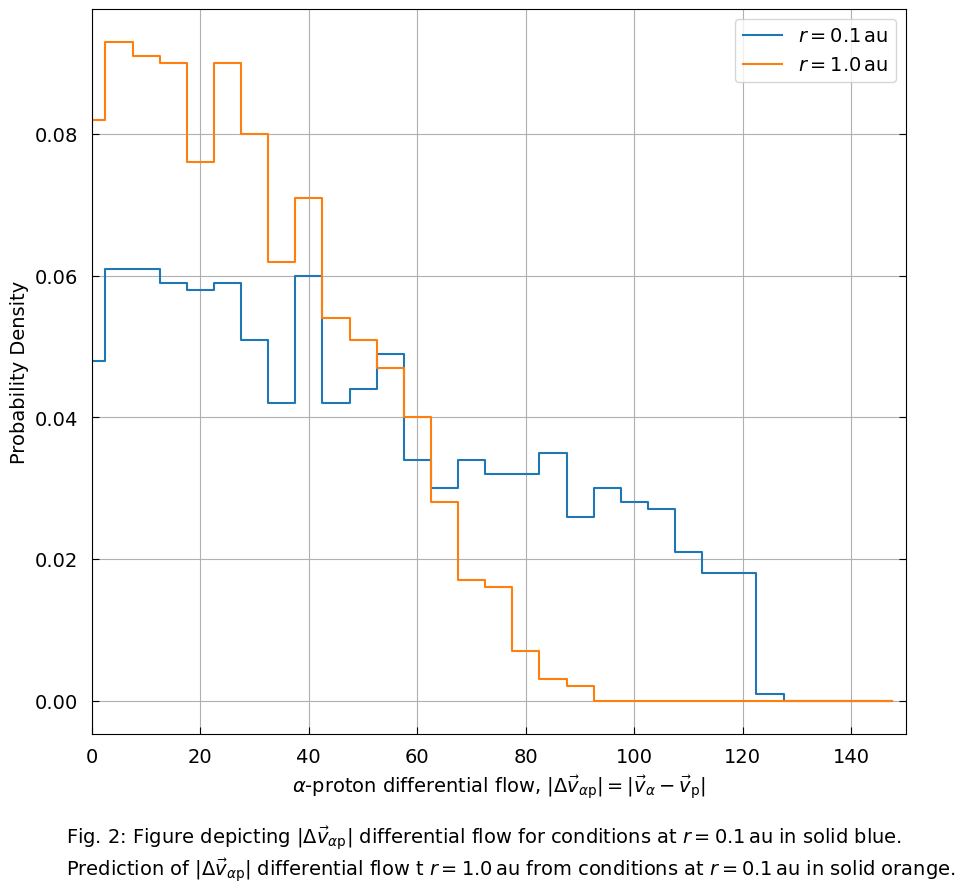

In [35]:
# Define arrays
theta = []
theta_pred = []

# Generate theta values for inputs and prediction
L = 1000  # The number of values you want to produce
for i in range(L):
    params = gen_params()
    while check_params(params) is False:
        params = gen_params()
    theta.append(float(abs(params["v_2"] - params["v_1"]).value))
    theta_pred.append(coal.diff_flow(**params)[0].value)
    print("\r", f"{(i / L) * 100:.2f} %", end="")

# Define constraints
xlim = 150
bin_num = 30

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

weg = np.ones_like(theta) / float(len(theta))
results, edges = np.histogram(
    theta, range=(0, xlim), weights=weg, bins=bin_num, density=1
)
binWidth = edges[1] - edges[0]
xs, ys = make_bars(edges[:-1], results * binWidth, binWidth / 2)
plt.plot(xs, ys, label=r"$r = 0.1 \, {\rm au}$")

weg = np.ones_like(theta_pred) / float(len(theta_pred))
results, edges = np.histogram(
    theta_pred, range=(0, xlim), weights=weg, bins=bin_num, density=1
)
binWidth = edges[1] - edges[0]
xs, ys = make_bars(edges[:-1], results * binWidth, binWidth / 2)
plt.plot(xs, ys, label=r"$r = 1.0 \, {\rm au}$")

# Adjust axes
plt.ylabel(r"Probability Density", fontsize=fs)
plt.xlabel(
    r"$\alpha$-proton differential flow, $| \Delta \vec{v}_{\alpha \rm p}| = |\vec{v}_{\alpha} - \vec{v}_{\rm p}|$",
    fontsize=fs,
)
plt.xlim(0, xlim)

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
    pad=10,
)

# Plot caption
txt = (
    r"Fig. 2: Figure depicting $|\Delta \vec{v}_{\alpha {\rm p}}|$ differential flow for conditions at $r = 0.1 \, {\rm au}$ in solid blue. "
    + f"\nPrediction "
    + r"of $|\Delta \vec{v}_{\alpha {\rm p}}|$ differential flow t $r = 1.0 \, {\rm au}$ from conditions at $r = 0.1 \, {\rm au}$ in solid orange."
)

plt.legend(loc="upper right", fontsize=fs)
plt.figtext(0.1, -0.04, txt, ha="left", fontsize=fs)
plt.grid()
plt.show()

[johnson2023]: https://docs.plasmapy.org/en/stable/bibliography.html

This histogram shows us the probability of observing a specific differential flow value, with the solid blue line representing observations in the near-Sun solar wind $r = 0.1 \, {\rm au}$. The solid orange line is the prediction for the near-Earth solar wind $r = 1.0 \, {\rm au}$, the prediction is made using the prior observations in solid blue and collisional analysis. It can be observed that a broad bi-modal distribution is observed in the near-Sun solar wind, whereas in the near-Earth solar wind a narrower bi-modal distribution is observed. This simulation is consistent with observations and predictions in [Johnson 2023][johnson2023], indicating that the large scale evolution of ion differential flow is principally affected by Coulomb collisions and that the preferential heating of $\alpha$-particles is largely limited to the corona.


[hellinger2011]: https://doi.org/10.1029/2011JA016674

Uniquely for the differential flow it can be normalized by the Alfven speed. To do this, the Alfven speed must first be calculated and magnetic field strength, $B$, must be scaled like the other parameters. Scaling value is also taken from [Hellinger 2011][hellinger2011].

$$
    v_{\rm A} = \frac{B}{\sqrt{\mu_{0}(n_{\alpha}m_{\alpha} + n_{\rm p}m_{\rm p})}}, \hspace{1.5cm} B(r) \propto r^{-1.6},
$$

where $\mu_{0}$ is the vacuum permeability. The histograms are produced in the same way as prior, except the data are sorted among 30 bins ranging from $\Delta \vec{v}_{\alpha {\rm p}}/v_{\rm A} = 0$ to $1.25 $. The following histograms show the differential flow scaled by the Alfven speed, blue-solid is the differential flow in near-Sun solar wind and the orange-solid is the prediction of the near-Earth differential flow from collisional analysis.

In [ ]:
# Define arrays
delta_a = []
delta_a_pred = []

# Generate theta values for inputs and prediction
for i in range(L):
    params = gen_params()
    while check_params(params) is False:
        params = gen_params()
    params["alfven"] = True
    arg3 = 1 * params["n_1"] + 4 * params["n_2"]
    delta_a.append(
        float((abs(params["v_2"] - params["v_1"])) / va(params["B"], arg3, "p+"))
    )
    delta_a_pred.append(coal.diff_flow(**params)[0].value)
    print("\r", f"{(i / L) * 100:.2f} %", end="")

xlim = 1.5

fig = plt.figure(figsize=[figwidth, figheight])

weg = np.ones_like(delta_a) / float(len(delta_a))
results, edges = np.histogram(
    delta_a, range=(0, xlim), weights=weg, bins=bin_num, density=1
)
binWidth = edges[1] - edges[0]
xs, ys = make_bars(edges[:-1], results * binWidth, binWidth / 2)
plt.plot(xs, ys, label=r"$r = 0.1 \, {\rm au}$")

weg = np.ones_like(delta_a_pred) / float(len(delta_a_pred))
results, edges = np.histogram(
    delta_a_pred, range=(0, xlim), weights=weg, bins=bin_num, density=1
)
binWidth = edges[1] - edges[0]
xs, ys = make_bars(edges[:-1], results * binWidth, binWidth / 2)
plt.plot(xs, ys, label=r"$r = 1.0 \, {\rm au}$")

# Adjust axes
plt.ylabel(r"Probability Density", fontsize=fs)
plt.xlabel(
    r"$\alpha$-proton differential flow, $|\Delta \vec{v}_{\alpha \rm p}|/v_{\rm A} = |\vec{v}_{\alpha} - \vec{v}_{\rm p}|/v_{\rm A}$",
    fontsize=fs,
)
plt.xlim(0, xlim)

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
    pad=10,
)

# Plot caption
txt = (
    r"Fig. 3: Figure depicting $|\Delta \vec{v}_{\alpha {\rm p}}|/v_{\rm A}$ differential flow for conditions at $r = 0.1 \, {\rm au}$ in solid blue. "
    + f"\nPrediction "
    + r"of $|\Delta \vec{v}_{\alpha {\rm p}}|/v_{\rm A}$ differential flow at $r = 1.0 \, {\rm au}$ from conditions at $r = 0.1 \, {\rm au}$ in solid orange."
)

plt.legend(loc="upper right", fontsize=fs)
plt.figtext(0.1, -0.04, txt, ha="left", fontsize=fs)
plt.grid()
plt.show()

 2.20 %

[cdaweb]: https://cdaweb.gsfc.nasa.gov/
[maruca2011]: https://www.doi.org/10.1103/PhysRevLett.107.201101
[maruca2013]: https://www.doi.org/10.1103/PhysRevLett.111.241101

## Comparison

Now data can be obtained from spacecraft in order to compare the prediction with real world observations, data is accessed from the NASA [CDA Web][cdaweb] system. WIND is located at approximately $r = 1.0 \, {\rm au}$ so it is the ideal candidate to test the $r = 1.0 \, {\rm au}$ prediction with, the proton and $\alpha$-particle bulk speeds are required in order to facilitate a comparison.

To start, the value of $\Delta \vec{v}_{\alpha {\rm p}}$ is calculated. Then, in a similar manner as the prior sections, a probability distribution of the $\alpha$-proton differential flow for the data set is created. With the data being sorted among 35 bins ranging from $\Delta \vec{v}_{\alpha {\rm p}} = 0$ to $150$, the count of the number of data in each bin was divided by the total number of data, with the $\Delta \vec{v}_{\alpha {\rm p}}$-width of the bin again being used to approximate probability density [Maruca 2011][maruca2011], [Maruca 2013][maruca2013].

In [ ]:
server = "https://cdaweb.gsfc.nasa.gov/hapi"
dataset = "WI_H1_SWE"
start = "2014-08-01T00:00:00"  # 1994/11/17 19:50:45
stop = "2014-10-01T00:00:00"  # 2023/06/18 23:57:52
parameters = "Proton_V_nonlin,Alpha_V_nonlin"

# Get data
data = hapi(server, dataset, parameters, start, stop)

theta_w = []
for i in range(len(data[0])):
    arg = abs(np.sqrt(data[0][i][2] ** 2 - data[0][i][1] ** 2))
    if arg > 0.1:
        theta_w.append(arg)

# Define constraints
xlim = 150
bin_num = 35

# Plot the results
fs = 14  # Default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

weg = np.ones_like(theta_w) / float(len(theta_w))
results, edges = np.histogram(
    theta_w, range=(0, xlim), weights=weg, bins=bin_num, density=1
)
binWidth = edges[1] - edges[0]
xs, ys = make_bars(edges[:-1], results * binWidth, binWidth / 2)
plt.plot(xs, ys, label=r"WIND @ $1.0 \, {\rm au}$")


# Adjust axes
plt.ylabel(r"Probability Density", fontsize=fs)
plt.xlabel(
    r"$\alpha$-proton differential flow, $|\Delta \vec{v}_{\alpha \rm p}| = |\vec{v}_{\alpha} - \vec{v}_{\rm p}|$",
    fontsize=fs,
)
plt.xlim(0, xlim)

plt.tick_params(
    which="both",
    direction="in",
    labelsize=fs,
    right=True,
    length=5,
    pad=10,
)

# Plot caption
txt = r"Fig. 4: Observations of $|\Delta \vec{v}_{\alpha \rm p}|$ from WIND, located at $r = 1.0 \, {\rm au}$."

plt.legend(loc="upper right", fontsize=fs)
plt.figtext(0.2, -0.02, txt, ha="left", fontsize=fs)
plt.grid()

[johnson2023]: https://docs.plasmapy.org/en/stable/bibliography.html

The bi-modal distribution in the probability density predicted by collisional analysis can be seen in observations from WIND, this is consistent with the findings of [Johnson 2023][johnson2023]. These results strongly suggest that outside of the corona, differential flow is principally affected by Coulomb collisions and that the preferential heating of $\alpha$-particles is largely limited to the corona.

